In [1]:
%load_ext autoreload
%autoreload 2

import time
from typing import Optional, Tuple, List, Dict, Any
import frame.frame_assembler as fa
import frame.frame as fr
import timeseries as ts
import histogram as hg
import plots as pt
from datetime import datetime
from elasticsearch import Elasticsearch
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import frame.frame_collection_stats as fcs
from lib import ESQuery

client = Elasticsearch("http://localhost:9200/", api_key="WGRuTF9wUUIzYVpjeXh5Wnl2RlA6Q3ZPUFJoZXRUX1NiX3NWQ0FGbHZEdw==")

def print_json(j):
    print(json.dumps(j, indent=4))

In [ ]:
### Duration Histogram Analysis

index_datetime = "2025-03-10"
time_from = f"{index_datetime}T04:20:00.0Z"
time_to = f"{index_datetime}T05:00:00.0Z"
namespace = "hifi_1"
index = f"jaeger-span-{index_datetime}*"
es_query = ESQuery(namespace).add_range(time_from,time_to)
es_query.add_service_and_op_name("digitiser-aggregator", "process_digitiser_event_list_message")
results_el = hg.get_min_max_time_by_metadata_timestamp(client, index, es_query)
(timestamps_el, results_el) = hg.process_min_max_range(results_el)

es_query = ESQuery(namespace).add_range(time_from,time_to)
es_query.add_service_and_op_name("trace-to-events", "process_digitiser_trace_message")
results_tr = hg.get_min_max_time_by_metadata_timestamp(client, index, es_query)
(timestamps_tr, results_tr) = hg.process_min_max_range(results_tr)

es_query = ESQuery(namespace).add_range(time_from,time_to)
es_query.add_service_and_op_name("digitiser-aggregator", "Frame")
result_fr = hg.get_durations(client, index, es_query, 500, 0, 50000)

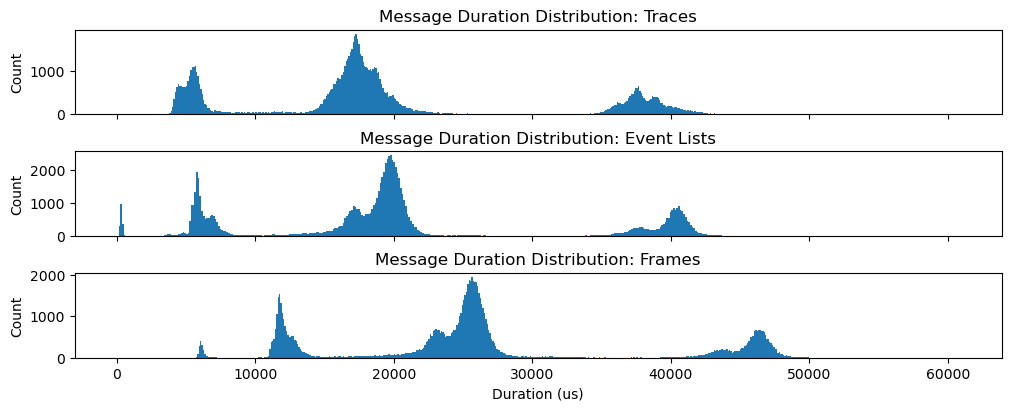

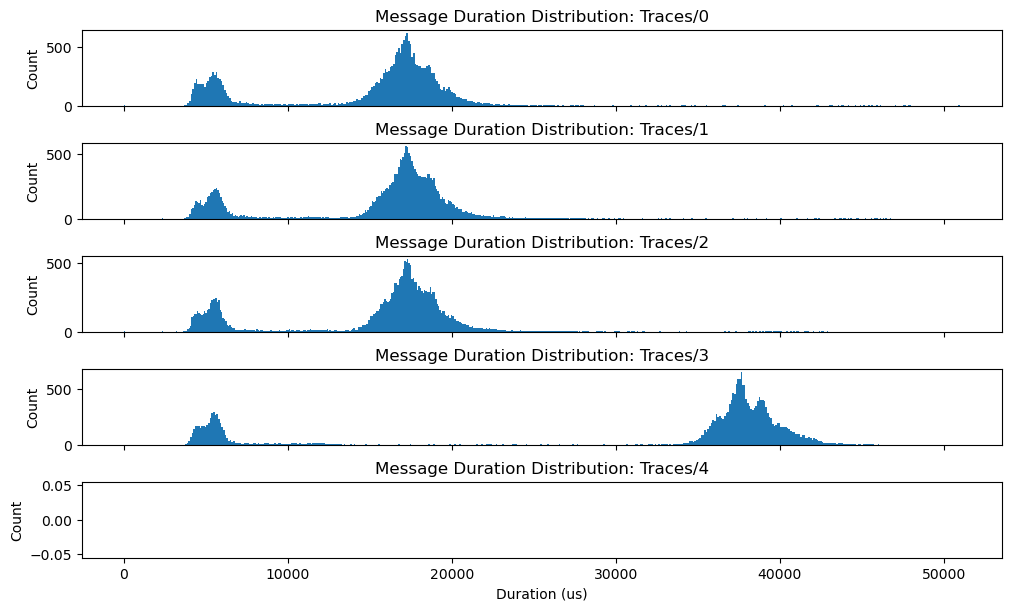

In [15]:
timestamps_category_tr = [int(t/20) % 5 for t in timestamps_tr]

traces = ("Traces", results_tr, [500])
eventlists = ("Event Lists", results_el, [500])
frames = ("Frames", [r["key"] for r in result_fr], [r["doc_count"] for r in result_fr])

hg.histograms([traces, eventlists, frames], height=4)
plt.show()

part_traces = []
for c in [0, 1, 2, 3, 4]:
    part_results_tr = [r for i,r in enumerate(results_tr) if timestamps_category_tr[i] == c]
    part_traces.append((f"Traces/{c}", part_results_tr, [500]))

hg.histograms(part_traces, height=6)
plt.show()

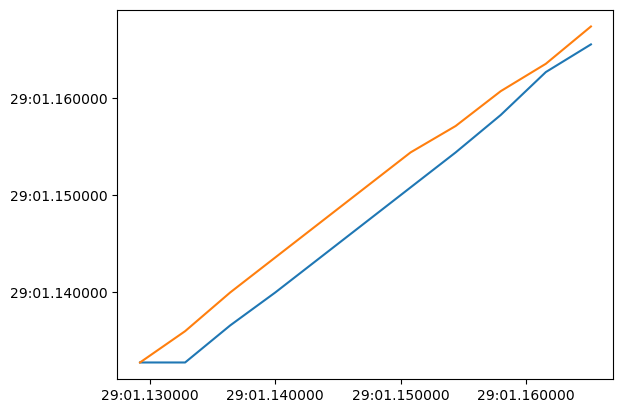

In [13]:
### Timestamp Analysis
index_datetime = "2025-03-05"
time_from = f"{index_datetime}T03:54:40.0Z"
time_to = f"{index_datetime}T03:55:00.0Z"
index = f"jaeger-span-{index_datetime}*"
namespace = "hifi_1"
format = "MM/dd hh"
bin_width = "1h"

def do_thing(client, eq_query, service_name, operation_name, hist_freq, format):
    serviceName_query = { "term": { "process.serviceName": service_name } }
    op_name_query = { "term": { "operationName": operation_name } }
    
    musts = eq_query.get_queries_with([serviceName_query, op_name_query])
    query = { "bool" : { "must": musts } }
    
    aggregations = {
        "by_metadata_timestamp": {
            "auto_date_histogram": {
                "field": "tag.metadata_timestamp",
                "buckets": 2
            },
            "aggregations": {
                "earliest_time": { "min": { "field": "tag.metadata_timestamp" } },
                "latest_time":   { "max": { "field": "tag.metadata_timestamp" } },
            }
        }
    }

    body = {
        "query": query,
        "aggregations": aggregations,
        "_source": False,
        "size": 0
    }
    result = client.search(index=index, body=body)
    return result.raw["aggregations"]["by_metadata_timestamp"]["buckets"]
do_thing(client, ESQuery(namespace),"trace-to-events", "process_digitiser_trace_message", bin_width, format)
x = [datetime.fromtimestamp(r["key"]/1_000_000_000) for r in result]
y1 = [datetime.fromtimestamp(r["earliest_time"]["value"]/1_000_000_000) for r in result]
y2 = [datetime.fromtimestamp(r["latest_time"]["value"]/1_000_000_000) for r in result]
plt.plot(x, y1)
plt.plot(x, y2)